In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import tensorflow.keras as Keras
from PIL import Image

from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
model_path = "models/1"

INPUT_SIZE = (256, 256)

In [5]:
model = Keras.models.load_model(model_path)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 252, 252, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)      

In [6]:
last_conv_layer_name = "conv2d_5"

In [10]:
model.inputs, model.get_layer(last_conv_layer_name)

([<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'sequential_input')>],
 <keras.layers.convolutional.conv2d.Conv2D at 0x1f65ea18e50>)

In [7]:
def get_img_array(img_path, img_size):
    img = Keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_arr = Keras.preprocessing.image.img_to_array(img)
    img_batched = np.expand_dims(img_arr, axis=0)
    return img_batched

In [11]:
def make_gradcam_heatmap(img_arr, model, last_conv_layer_name, pred_idx=None):
    grad_model = Keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_arr)
    
        if pred_idx is None:
            pred_idx = tf.argmax(preds[0])
        class_channel = preds[:, pred_idx]
    
    gradients = tape.gradient(class_channel, last_conv_layer_output)
    
    pooled_grads = tf.reduce_mean(gradients, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [29]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = Keras.preprocessing.image.load_img(img_path)
    img = Keras.preprocessing.image.img_to_array(img)
    
    heatmap = np.uint8(255 * heatmap)
    
    jet = cm.get_cmap("jet")
    
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    jet_heatmap = Keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = Keras.preprocessing.image.img_to_array(jet_heatmap)
    
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = Keras.preprocessing.image.array_to_img(superimposed_img)
    
    superimposed_img.save(cam_path)
    
    plt.imshow(superimposed_img)
    plt.axis("off")

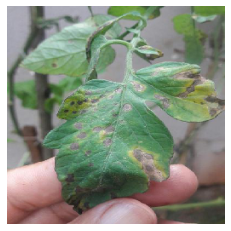

In [36]:
img_path = "test-images/early-blight-tomato-1550839948.jpg"

img_array = get_img_array(img_path, INPUT_SIZE)

plt.imshow(np.squeeze(img_array).astype("uint8"))
plt.axis("off");

In [37]:
class_names = pd.read_csv("assets/class_names.csv")["labels"].tolist()

pred = model.predict(img_array)
print(f"Predicted: {class_names[np.argmax(pred[0])]}")

1/1 [==============================] - 0s 42ms/step
Predicted: Potato___Late_blight


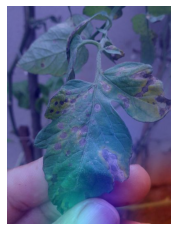

In [38]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(img_path, heatmap, alpha=0.6)